# Chicken and egg in molecular metadynamics
Create protein folding landmarks from scratch



In [7]:
from pypdb import get_pdb_file

id="1L2Y"
pdb=get_pdb_file(id)

f=open(id + ".pdb","w")
f.write(pdb)
f.close()

In [8]:
import nglview as nv

v = nv.NGLWidget()
v.add_component(id + ".pdb")
v.clear()
v.add_representation('cartoon', selection='all', color='green')
v

NGLWidget()

[7.261800588956257, 7.535826904869758, 7.49232268916437, 7.117213495460777, 7.127310927159626, 7.213558874625188, 6.903500050616645, 8.232328725249433, 7.892895110957647, 6.909364915481457, 7.543833116530451, 7.709488268975085, 7.904503675716316, 6.735177852929089, 7.305167013884422, 7.748098378508504, 6.8643904256307025, 7.339422657522633, 7.3788809559941315, 7.332624793823505, 7.924528377301039, 7.341504968217564, 7.676283693560163, 7.913096620672434, 7.677800952542764, 7.116227946240596, 7.658865797853272, 7.44955946634679, 6.822853138190509, 7.140609490558274, 7.532694721689282, 7.038425880456958, 7.810451665080357, 8.282942288313144, 7.155546287566879, 8.268021703170055, 7.334551667565551, 7.459238463634774, 7.301766374881416, 7.132892650338559, 8.087657101745355, 7.116687618369051, 7.900288808242863, 7.510697499915279, 7.815293732134192, 7.52540196648585, 6.8461236962157255, 7.6048650824058, 7.30084074052205, 7.311080695207982, 7.67487312596204, 7.128843812083204, 7.3294605392625

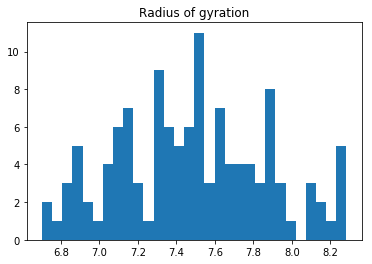

In [9]:
import math
import pybel
from pyDOE import lhs
from pypdb import describe_pdb
import matplotlib.pyplot as plt

pdb = id + ".pdb"
nres = int(describe_pdb(id)['nr_residues'])

out='conf%d.pdb'

# number of steps to twist a dihedral
nsteps = 12

# number of iterations; alltogether niter * nsteps random conformers are generated
#niter = 200
niter = 10

conf = 1
rgs = []

mols = list(pybel.readfile('pdb',pdb))
mol=mols[0]

# if I knew SMARTS better, oxygens would not have been counted
pattern = '[NH3]-[CH]-C(=O)'
for _ in range(nres-1):
    pattern += '-N-C-C(=O)'
    
sp = pybel.Smarts(pattern)

match = sp.findall(mol)

if len(match) != 1:
    print("backbone pattern not matched")
    raise
    
match = match[0]
    
def set_phi(mol,match,r,phi):
    a1 = mol.atoms[4*(r-1)-2].OBAtom
    a2 = mol.atoms[4*(r-1)].OBAtom
    a3 = mol.atoms[4*(r-1)+1].OBAtom
    a4 = mol.atoms[4*(r-1)+2].OBAtom
    mol.OBMol.SetTorsion(a1,a2,a3,a4,phi/180*math.pi)
    
def set_psi(mol,match,r,phi):
    a1 = mol.atoms[4*(r-1)].OBAtom
    a2 = mol.atoms[4*(r-1)+1].OBAtom
    a3 = mol.atoms[4*(r-1)+2].OBAtom
    a4 = mol.atoms[4*(r-1)+4].OBAtom
    mol.OBMol.SetTorsion(a1,a2,a3,a4,phi/180*math.pi)
    
def rg(mol):
    n = len(mol.atoms)
    
    x = [mol.atoms[i].coords for i in range(n)]
    
    mass = [mol.atoms[i].exactmass for i in range(n)]
    xm = [(m*i,m*j,m*k) for (i,j,k),m in zip(x,mass)]
    tmass = sum(mass)
    rr = sum(mi*i+mj*j+mk*k for (i,j,k),(mi,mj,mk) in zip(x,xm))
    mm = sum((sum(i)/tmass)**2 for i in zip(*xm))
    return math.sqrt(rr/tmass - mm)

rgs = []

for _ in range(niter):
    phi = lhs(nres - 2, nsteps)
    psi = lhs(nres - 2, nsteps)

    for s in range(nsteps):
        for r in range(2,nres):
            set_phi(mol,match,r,phi[s][r-2] * 360)
            set_psi(mol,match,r,psi[s][r-2] * 360)
            
        fn = out % conf
        mol.write('pdb',fn,overwrite=True)
        rgs.append(rg(mol))
        conf += 1
            
print(rgs)

fig, ax = plt.subplots()
n, bins, patches = ax.hist(rgs, 30)
ax.set_title('Radius of gyration')
plt.show()



In [11]:
import nglview as nv

v = nv.show_url("conf12.pdb")
v.clear()
v.add_representation('cartoon',selection='all',color='green')
v

NGLWidget()

In [18]:
minim_mdp = '''
; minim.mdp - used as input into grompp to generate em.tpr
; Parameters describing what to do, when to stop and what to save
integrator  = steep         ; Algorithm (steep = steepest descent minimization)
emtol       = 100.0        ; Stop minimization when the maximum force < 1000.0 kJ/mol/nm
emstep      = 0.01          ; Minimization step size
nsteps      = 50000         ; Maximum number of (minimization) steps to perform

; Parameters describing how to find the neighbors of each atom and how to calculate the interactions
nstlist         = 1         ; Frequency to update the neighbor list and long range forces
cutoff-scheme   = Verlet    ; Buffered neighbor searching
ns_type         = grid      ; Method to determine neighbor list (simple, grid)
coulombtype     = PME       ; Treatment of long range electrostatic interactions
rcoulomb        = 1.0       ; Short-range electrostatic cut-off
rvdw            = 1.0       ; Short-range Van der Waals cut-off
pbc             = xyz       ; Periodic Boundary Conditions in all 3 dimensions
'''
f=open('minim.mdp','w')
f.write(minim_mdp)
f.close()

minim_sh = '''
minone() {
	in=$1
	
	base=$(basename $in .pdb)
	
#	echo Prepare topology
	gmx pdb2gmx -f $base.pdb -o $base.gro -p $base -i $base -water spce -ff amber99 -ignh
	
#	echo Add box
	gmx editconf -f $base.gro -o $base-box.gro -d 1.0 -bt cubic
	
	# not solvating
	
	# no ions
	
#	echo Minimize
	gmx grompp -f minim.mdp -c $base-box.gro -p $base.top -o $base-min.tpr -po $base-min.mdp
	gmx mdrun -v -deffnm $base-min
}

nproc=4

nfil=$(ls conf*.pdb | wc -l)

for p in $(seq 1 $nproc); do
	(
		i=$p
		while [ $i -le $nfil ]; do
			minone conf$i.pdb
			i=$(($i + $nproc))
		done
	) &
done


wait
'''

f=open('minim.sh','w')
f.write(minim_sh)
f.close()

!bash minim.sh


                     :-) GROMACS - gmx pdb2gmx, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

Residue 936 29
Sorting it all out...
Atomtype 67
Reading residue database... (amber99)
Residue 32Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.rtp
Residue 93
Sorting it all out...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.rtp
Residue 639
Sorting it all out...
Residue 65Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.rtp
Residue 78Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.rtp
Residue 855
Sorting it all out...
Residue 93
Sorting it all out...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.rtp
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.hdb
Residue 109
Sorting it all out...
Residue 109
Sorting it all out...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.rtp
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.rtp
Residue 125
Sorting it all out...
Residue 124Opening force field file /gromacs/share/gromacs/top/am

Read 304 atoms
Volume: 0.001 nm^3, corresponds to roughly 0 electrons
No velocities found
    system size :  1.870  1.982  2.323 (nm)
    diameter    :  2.507               (nm)
    center      :  0.511 -0.897 -1.785 (nm)
    box vectors :  0.100  0.100  0.100 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :   0.00               (nm^3)
    shift       :  1.743  3.151  4.039 (nm)
new center      :  2.254  2.254  2.254 (nm)
new box vectors :  4.507  4.507  4.507 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  :  91.57               (nm^3)
                     :-) GROMACS - gmx editconf, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jir

                      :-) GROMACS - gmx grompp, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

                      :-) GROMACS - gmx mdrun, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS dev

                     :-) GROMACS - gmx pdb2gmx, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.arn
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.arn
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.arn
Checking for duplicate atoms....
Generating any missing hydrogen atoms and/or adding termini.
Now there are 20 residues with 304 atoms
Making bonds...
Number of bonds was 311, now 310
Generating angles, dihedrals and pairs...
Before cleaning: 818 pairs
Before cleaning: 843 dihedrals
Keeping all generated dihedrals
Making cmap torsions...
There are  843 dihedrals,   61 impropers,  565 angles
           812 pairs,      310 bonds and     0 virtual sites
Total mass 2170.450 a.m.u.
Total charge 1.000 e
Writing topology

Writing coordinate file...
		--------- PLEASE NOTE ------------
You have successfully generated a topology from: conf6.pdb.
The Amber99 force field and the spce water model are used.
		--------- ETON ESAELP ------------

GROMACS reminds you: "Have a Nice Day"

                      :-) GROMACS - gmx grompp, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

If you are sure all warnings are harmless, use the -maxwarn option.

For more information and tips for troubleshooting, please check the GROMACS
website at http://www.gromacs.org/Documentation/Errors
-------------------------------------------------------
Excluding 3 bonded neighbours molecule type 'Protein_chain_A'
Removing all charge groups because cutoff-scheme=Verlet
Removing all charge groups because cutoff-scheme=Verlet
Analysing residue names:
Analysing residue names:
There are:    20    Protein residues
Analysing Protein...
Number of degrees of freedom in T-Coupling group rest is 909.00
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 36x36x36, spacing 0.114 0.114 0.114
Estimate for the relative computational load of the PME mesh part: 0.85

NOTE 3 [file minim.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spa

-------------------------------------------------------
Program:     gmx mdrun, version 2018.6
Source file: src/gromacs/options/options.cpp (line 189)
Function:    void gmx::internal::OptionSectionImpl::finish()

Error in user input:
Invalid input values
  In option s
    Required option was not provided, and the default file 'topol' does not
    exist or is not accessible.
    The following extensions were tried to complete the file name:
      .tpr

For more information and tips for troubleshooting, please check the GROMACS
website at http://www.gromacs.org/Documentation/Errors
-------------------------------------------------------
                     :-) GROMACS - gmx pdb2gmx, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hin

Read 'TC5B', 154 atoms
Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.
There are 1 chains and 0 blocks of water and 20 residues with 154 atoms

  chain  #res #atoms
  1 'A'    20    154  

All occupancies are one
Read 'TC5B', 154 atoms

Using the Amber99 force field in directory amber99.ff

Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.
There are 1 chains and 0 blocks of water and 20 residues with 154 atoms

  chain  #res #atoms
  1 'A'    20    154  

All occupancies are one
Read 'TC5B', 154 atoms
Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.
There are 1 chains and 0 blocks of water and 20 residues with 154 atoms

  chain  #res #atoms
  1 'A'    20    154  

All occupancies are one
Opening force field file /gromacs/share/gromacs/top/amber99.ff/atomtypes.atp
Atomtype 32Opening force field file /gromacs/share/gromacs/top/amber99.ff/atomtypes.atp
Atomtype 54Opening f

                     :-) GROMACS - gmx editconf, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS d

                     :-) GROMACS - gmx editconf, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS d

                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS development team at
Uppsala University, Stockholm University and
the Royal Institute of Technology, Sweden.
check out http://www.gromacs.org for more information.

GROMACS is free software; you can redistribute it and/or modify it
under the terms of the GNU Lesser General Public License
as published by the Free Software Foundation; either version 2.1
of the License, or (at your option) any later version.

GROMACS:      gmx grompp, version 2018.6
Executable:   /gromacs/bin.AVX2_256/gmx
Data prefix:  /gromacs
Working dir:  /home/ljocha/MOUNTED
Command line:
  gmx grompp -f minim.mdp -c conf10-box.gro -p conf10.top -o conf10-min.tpr -po conf10-min.mdp

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

NOTE 2 [file conf12.top, line 2984]:
  System has n

                     :-) GROMACS - gmx pdb2gmx, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

Residue 125
Sorting it all out...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.hdb

Using the Amber99 force field in directory amber99.ff

Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.hdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.hdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.n.tdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.c.tdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.r2b
Reading conf16.pdb...
Processing chain 1 'A' (154 atoms, 20 residues)
Identified residue ASN1 as a starting terminus.
Identified residue SER20 as a ending terminus.
8 out of 8 lines of specbond.dat converted successfully
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.arn
Opening for

Residue 98
Writing coordinate file...
Residue 109
Sorting it all out...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.rtp
		--------- PLEASE NOTE ------------
You have successfully generated a topology from: conf16.pdb.
The Amber99 force field and the spce water model are used.
		--------- ETON ESAELP ------------

GROMACS reminds you: "Uh-oh, We're In Trouble" (Shampoo)

Residue 110                     :-) GROMACS - gmx editconf, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pal

                      :-) GROMACS - gmx grompp, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de


NOTE 2 [file conf16.top, line 2984]:
  System has non-zero total charge: 1.000000
  Total charge should normally be an integer. See
  http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
  for discussion on how close it should be to an integer.
  



WARNING 1 [file conf16.top, line 2984]:
  You are using Ewald electrostatics in a system with net charge. This can
  lead to severe artifacts, such as ions moving into regions with low
  dielectric, due to the uniform background charge. We suggest to
  neutralize your system with counter ions, possibly in combination with a
  physiological salt concentration.


++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
J. S. Hub, B. L. de Groot, H. Grubmueller, G. Groenhof
Quantifying Artifacts in Ewald Simulations of Inhomogeneous Systems with a Net
Charge
J. Chem. Theory Comput. 10 (2014) pp. 381-393
-------- -------- --- Thank You --- -------- --------

Removing all charge groups because cutoff-scheme=Verlet
Analysing residue nam


-------------------------------------------------------
Program:     gmx mdrun, version 2018.6
Source file: src/gromacs/options/options.cpp (line 189)
Function:    void gmx::internal::OptionSectionImpl::finish()

Error in user input:
Invalid input values
  In option s
    Required option was not provided, and the default file 'topol' does not
    exist or is not accessible.
    The following extensions were tried to complete the file name:
      .tpr

For more information and tips for troubleshooting, please check the GROMACS
website at http://www.gromacs.org/Documentation/Errors
-------------------------------------------------------

-------------------------------------------------------
Program:     gmx mdrun, version 2018.6
Source file: src/gromacs/options/options.cpp (line 189)
Function:    void gmx::internal::OptionSectionImpl::finish()

Error in user input:
Invalid input values
  In option s
    Required option was not provided, and the default file 'topol' does not
    exist 

Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.
There are 1 chains and 0 blocks of water and 20 residues with 154 atoms

  chain  #res #atoms
  1 'A'    20    154  

All occupancies are one
Residue 86Opening force field file /gromacs/share/gromacs/top/amber99.ff/atomtypes.atp
Atomtype 67
Reading residue database... (amber99)
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.rtp
Residue 31Read 'TC5B', 154 atoms
Residue 93
Sorting it all out...
Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.
There are 1 chains and 0 blocks of water and 20 residues with 154 atoms

  chain  #res #atoms
  1 'A'    20    154  

All occupancies are one
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.rtp
Opening force field file /gromacs/share/gromacs/top/amber99.ff/atomtypes.atp
Residue 109
Sorting it all out...
Atomtype 67
Reading residue database... (amber99)
Opening force field file /g

8 out of 8 lines of specbond.dat converted successfully
Now there are 20 residues with 304 atoms
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.arn
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.arn
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.arn
Checking for duplicate atoms....
Making bonds...
Number of bonds was 311, now 310
Generating any missing hydrogen atoms and/or adding termini.
Generating angles, dihedrals and pairs...
Now there are 20 residues with 304 atoms
Before cleaning: 818 pairs
Before cleaning: 843 dihedrals
Keeping all generated dihedrals
Making cmap torsions...
There are  843 dihedrals,   61 impropers,  565 angles
           812 pairs,      310 bonds and     0 virtual sites
Total mass 2170.450 a.m.u.
Total charge 1.000 e
Writing topology
Making bonds...
Number of bonds was 311, now 310
Generating angles, dihedrals and pairs...
Before cleaning: 818 pairs
Before cleaning: 843 dihedrals
Keeping all ge

Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.r2b
                     :-) GROMACS - gmx editconf, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk H

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

NOTE 2 [file conf19.top, line 2984]:
  System has non-zero total charge: 1.000000
  Total charge should normally be an integer. See
  http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
  for discussion on how close it should be to an integer.
  



WARNING 1 [file conf19.top, line 2984]:
  You are using Ewald electrostatics in a system with net charge. This can
  lead to severe artifacts, such as ions moving into regions with low
  dielectric, due to the uniform background charge. We suggest to
  neutralize your system with counter ions, possibly in combination with a
  physiological salt concentration.


++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
J. S. Hub, B. L. de Groot, H. Grubmueller, G. Groenhof
Quantifying Artifacts in Ewald Simulations of Inhomogeneous Systems with a Net
Charge
J. Chem. Theory Comput. 10 (2014) pp. 381-393
-------- -------- --- Thank You --- -------- --------


NOTE 1 [file m

Read 304 atoms
Volume: 0.001 nm^3, corresponds to roughly 0 electrons
No velocities found
    system size :  2.085  1.939  1.877 (nm)
    diameter    :  2.223               (nm)
    center      : -0.668  5.984 -4.080 (nm)
    box vectors :  0.100  0.100  0.100 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :   0.00               (nm^3)
    shift       :  2.779 -3.873  6.191 (nm)
new center      :  2.112  2.112  2.112 (nm)
new box vectors :  4.223  4.223  4.223 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  :  75.32               (nm^3)
Removing all charge groups because cutoff-scheme=Verlet
Analysing residue names:
There are:    20    Protein residues
Analysing Protein...
Number of degrees of freedom in T-Coupling group rest is 909.00
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 36x36x36, spacing 0.114 0.114 0.114
Estimate for the relative computational load of the PME mesh part: 0.85

NOTE 3 [file minim.mdp]:
  The

Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.r2b
Reading conf23.pdb...

-------------------------------------------------------
Program:     gmx mdrun, version 2018.6
Source file: src/gromacs/options/options.cpp (line 189)
Function:    void gmx::internal::OptionSectionImpl::finish()

Error in user input:
Invalid input values
  In option s
    Required option was not provided, and the default file 'topol' does not
    exist or is not accessible.
    The following extensions were tried to complete the file name:
      .tpr

For more information and tips for troubleshooting, please check the GROMACS
website at http://www.gromacs.org/Documentation/Errors
-------------------------------------------------------
                     :-) GROMACS - gmx pdb2gmx, 2018.6 (-:

                            GROMACS is written by:
   

Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.
There are 1 chains and 0 blocks of water and 20 residues with 154 atoms

  chain  #res #atoms
  1 'A'    20    154  

All occupancies are one
Opening force field file /gromacs/share/gromacs/top/amber99.ff/atomtypes.atp
Atomtype 67
Reading residue database... (amber99)
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.rtp
Residue 88                      :-) GROMACS - gmx mdrun, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
Residue 89    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
Residue 90   Viveca Lindahl  rsson      Justin A. Lemkul 
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu

Processing chain 1 'A' (154 atoms, 20 residues)
Identified residue ASN1 as a starting terminus.
Identified residue SER20 as a ending terminus.
8 out of 8 lines of specbond.dat converted successfully
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.arn
Read 304 atoms
Volume: 0.001 nm^3, corresponds to roughly 0 electrons
No velocities found
    system size :  2.119  2.393  1.334 (nm)
    diameter    :  2.427               (nm)
    center      : -4.022  5.046 -0.981 (nm)
    box vectors :  0.100  0.100  0.100 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :   0.00               (nm^3)
    shift       :  6.236 -2.833  3.194 (nm)
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.arn
new center      :  2.214  2.214  2.214 (nm)
new box vectors :  4.427  4.427  4.427 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  :  86.79               (nm^3)
Opening force field file /gromacs/share/gromacs/top/amber99.ff/r


Writing coordinate file...
Read 304 atoms
Volume: 0.001 nm^3, corresponds to roughly 0 electrons
No velocities found
    system size :  2.186  1.997  1.884 (nm)
    diameter    :  2.664               (nm)
    center      : -0.320  5.186 -2.681 (nm)
    box vectors :  0.100  0.100  0.100 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :   0.00               (nm^3)
    shift       :  2.653 -2.854  5.013 (nm)
new center      :  2.332  2.332  2.332 (nm)
new box vectors :  4.664  4.664  4.664 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  : 101.47               (nm^3)
                      :-) GROMACS - gmx grompp, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis

Generated 2145 of the 2145 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5
Generated 2145 of the 2145 1-4 parameter combinations
                      :-) GROMACS - gmx mdrun, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, B

Data prefix:  /gromacs
Working dir:  /home/ljocha/MOUNTED
Command line:
  gmx mdrun -v -deffnm conf24-min

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

NOTE 2 [file conf21.top, line 2984]:
  System has non-zero total charge: 1.000000
  Total charge should normally be an integer. See
  http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
  for discussion on how close it should be to an integer.
  



WARNING 1 [file conf21.top, line 2984]:
  You are using Ewald electrostatics in a system with net charge. This can
  lead to severe artifacts, such as ions moving into regions with low
  dielectric, due to the uniform background charge. We suggest to
  neutralize your system with counter ions, possibly in combination with a
  physiological salt concentration.


++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
J. S. Hub, B. L. de Groot, H. Grubmueller, G. Groenhof
Quantifying Artifacts in Ewald Simulations of Inhomogeneous Systems with a Net
Charge
J. Chem. 

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'
Residue 109
Sorting it all out...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.rtp

NOTE 2 [file conf22.top, line 2984]:
  System has non-zero total charge: 1.000000
  Total charge should normally be an integer. See
  http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
  for discussion on how close it should be to an integer.
  



WARNING 1 [file conf22.top, line 2984]:
  You are using Ewald electrostatics in a system with net charge. This can
  lead to severe artifacts, such as ions moving into regions with low
  dielectric, due to the uniform background charge. We suggest to
  neutralize your system with counter ions, possibly in combination with a
  physiological salt concentration.


++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
J. S. Hub, B. L. de Groot, H. Grubmueller, G. Groenhof
Quantifying Artifacts in Ewald Simulations of Inhomogeneous Systems with a Net
Charge
J. Chem. Th

Read 'TC5B', 154 atoms
		--------- PLEASE NOTE ------------
You have successfully generated a topology from: conf27.pdb.
The Amber99 force field and the spce water model are used.
		--------- ETON ESAELP ------------

GROMACS reminds you: "It's Calling Me to Break my Bonds, Again..." (Van der Graaf)

Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.
There are 1 chains and 0 blocks of water and 20 residues with 154 atoms

  chain  #res #atoms
  1 'A'    20    154  

All occupancies are one
Opening force field file /gromacs/share/gromacs/top/amber99.ff/atomtypes.atp
Atomtype 67
Reading residue database... (amber99)
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.rtp
Residue 93
Sorting it all out...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.rtp
Residue 99
Writing coordinate file...
Residue 109
Sorting it all out...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.rtp
Residue 125
Sort

Read 'TC5B', 154 atoms
Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.
There are 1 chains and 0 blocks of water and 20 residues with 154 atoms

  chain  #res #atoms
  1 'A'    20    154  

All occupancies are one
Opening force field file /gromacs/share/gromacs/top/amber99.ff/atomtypes.atp
Atomtype 12Read 304 atoms
Volume: 0.001 nm^3, corresponds to roughly 0 electrons
No velocities found
    system size :  2.085  1.817  2.159 (nm)
    diameter    :  2.311               (nm)
    center      : -4.347  4.882  1.541 (nm)
    box vectors :  0.100  0.100  0.100 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :   0.00               (nm^3)
    shift       :  6.502 -2.727  0.615 (nm)
new center      :  2.155  2.155  2.155 (nm)
new box vectors :  4.311  4.311  4.311 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  :  80.09               (nm^3)
Atomtype 67
Reading residue database... (amber99)
Opening force field f

Read 304 atoms
Volume: 0.001 nm^3, corresponds to roughly 0 electrons
No velocities found
    system size :  1.778  2.289  2.049 (nm)
    diameter    :  2.706               (nm)
    center      : -4.638  3.487 -1.028 (nm)
    box vectors :  0.100  0.100  0.100 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :   0.00               (nm^3)
    shift       :  6.991 -1.134  3.381 (nm)
new center      :  2.353  2.353  2.353 (nm)
new box vectors :  4.706  4.706  4.706 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  : 104.23               (nm^3)
Generated 2145 of the 2145 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5
Generated 2145 of the 2145 1-4 parameter combinations
Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

NOTE 2 [file conf28.top, line 2984]:
  System has non-zero total charge: 1.000000
  Total charge should normally be an integer. See
  http://www.gromacs.org/Documentation/Floating_Point_Arithme

Using a fourier grid of 40x40x40, spacing 0.108 0.108 0.108
Estimate for the relative computational load of the PME mesh part: 0.89

NOTE 3 [file minim.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.


This run will generate roughly 0 Mb of data

There were 3 notes

There was 1 warning

-------------------------------------------------------
Program:     gmx grompp, version 2018.6
Source file: src/gromacs/gmxpreprocess/grompp.cpp (line 2406)

Fatal error:
Too many warnings (1).
If you are sure all warnings are harmless, use the -maxwarn option.

For more information and tips for troubleshooting, please check the GROMACS
website at http://www.gromacs.org/Documentation/Errors
-------------------------------------------------------
                     :-) GROMACS - gmx editconf, 2018.6 (-:

                            GROMACS is wri

Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.
There are 1 chains and 0 blocks of water and 20 residues with 154 atoms

  chain  #res #atoms
  1 'A'    20    154  

All occupancies are one
Opening force field file /gromacs/share/gromacs/top/amber99.ff/atomtypes.atp
Atomtype 67
Reading residue database... (amber99)
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.rtp
Residue 93
Sorting it all out...
                      :-) GROMACS - gmx mdrun, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulen

Removing all charge groups because cutoff-scheme=Verlet
Analysing residue names:

Using the Amber99 force field in directory amber99.ff

Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.rtp
Residue 117Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.r2b
Residue 119Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.r2b
There are:    20    Protein residues
Analysing Protein...
Residue 124Reading conf29.pdb...
Number of degrees of freedom in T-Coupling group rest is 909.00
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 36x36x36, spacing 0.116 0.116 0.116
Estimate for the relative computational load of the PME mesh part: 0.85

NOTE 3 [file minim.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid 

Residue 84Read 304 atoms
Residue 85Volume: 0.001 nm^3, corresponds to roughly 0 electrons
No velocities found
Residue 86    system size :  1.743  1.840  1.826 (nm)
    diameter    :  2.123               (nm)
    center      : -5.703  6.003  3.938 (nm)
Residue 87    box vectors :  0.100  0.100  0.100 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
Residue 90    box volume  :   0.00               (nm^3)
    shift       :  7.764 -3.942 -1.876 (nm)
Residue 91new center      :  2.061  2.061  2.061 (nm)
new box vectors :  4.123  4.123  4.123 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  :  70.06               (nm^3)
Residue 93
Sorting it all out...

Using the Amber99 force field in directory amber99.ff

Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.rtp
Residue 109
Sorting it all out...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.rtp
Residue 125
Sorting it all out...
Opening force field file /gromacs/share/gromacs/top/a

Number of bonds was 311, now 310
Generating angles, dihedrals and pairs...
Before cleaning: 818 pairs
Before cleaning: 843 dihedrals
Keeping all generated dihedrals
Making cmap torsions...
There are  843 dihedrals,   61 impropers,  565 angles
           812 pairs,      310 bonds and     0 virtual sites
Total mass 2170.450 a.m.u.
Total charge 1.000 e
Writing topology
		--------- PLEASE NOTE ------------
You have successfully generated a topology from: conf29.pdb.
The Amber99 force field and the spce water model are used.
		--------- ETON ESAELP ------------

GROMACS reminds you: "It was something to at least have a choice of nightmares" (Joseph Conrad)

Generated 2145 of the 2145 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5
Generated 2145 of the 2145 1-4 parameter combinations
                     :-) GROMACS - gmx editconf, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. B

  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS development team at
Uppsala University, Stockholm University and
the Royal Institute of Technology, Sweden.
check out http://www.gromacs.org for more information.

GROMACS is free software; you can redistribute it and/or modify it
under the terms of the GNU Lesser General Public License
as published by the Free Software Foundation; either version 2.1
of the License, or (at your option) any later version.

GROMACS:      gmx grompp, version 2018.6
Executable:   /gromacs/bin.AVX2_256/gmx
Data prefix:

Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.r2b
Reading conf36.pdb...

NOTE 1 [file minim.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Setting the LD random seed to 750938434
Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

NOTE 2 [file conf29.top, line 2984]:
  System has non-zero total charge: 1.000000
  Total charge should normally be an integer. See
  http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
  for discussion on how close it should be to an integer.
  



WARNING 1 [file conf29.top, line 2984]:
  You are using Ewald electrostatics in a system with net charge. This can
  lead to severe artifacts, such as ions moving into regions with low
  dielectric, due t

Making bonds...
Number of bonds was 311, now 310
Generating angles, dihedrals and pairs...

-------------------------------------------------------
Before cleaning: 818 pairs
Program:     gmx mdrun, version 2018.6
Source file: src/gromacs/options/options.cpp (line 189)
Function:    void gmx::internal::OptionSectionImpl::finish()

Error in user input:
Invalid input values
  In option s
    Required option was not provided, and the default file 'topol' does not
    exist or is not accessible.
    The following extensions were tried to complete the file name:
      .tpr

For more information and tips for troubleshooting, please check the GROMACS
website at http://www.gromacs.org/Documentation/Errors
-------------------------------------------------------
Before cleaning: 843 dihedrals
Keeping all generated dihedrals
Making cmap torsions...
There are  843 dihedrals,   61 impropers,  565 angles
           812 pairs,      310 bonds and     0 virtual sites
Total mass 2170.450 a.m.u.
Total cha

Residue 109
Sorting it all out...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.rtp
Read 304 atoms
Volume: 0.001 nm^3, corresponds to roughly 0 electrons
No velocities found
Residue 110    system size :  2.620  1.996  1.907 (nm)
    diameter    :  2.974               (nm)
    center      : -3.171  6.294  6.370 (nm)
    box vectors :  0.100  0.100  0.100 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :   0.00               (nm^3)
    shift       :  5.657 -3.807 -3.883 (nm)
new center      :  2.487  2.487  2.487 (nm)
new box vectors :  4.974  4.974  4.974 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  : 123.02               (nm^3)
Residue 125
Sorting it all out...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.hdb

GROMACS reminds you: "If you want to destroy my sweater, hold this thread as I walk away." (Weezer)

Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.hdb
Opening for

Generated 2145 of the 2145 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5
Generated 2145 of the 2145 1-4 parameter combinations
		--------- PLEASE NOTE ------------
You have successfully generated a topology from: conf33.pdb.
The Amber99 force field and the spce water model are used.
		--------- ETON ESAELP ------------

GROMACS reminds you: "Act like Prometheus would" (Gogol Bordello)


Writing coordinate file...
Excluding 3 bonded neighbours molecule type 'Protein_chain_A'
		--------- PLEASE NOTE ------------
You have successfully generated a topology from: conf34.pdb.
The Amber99 force field and the spce water model are used.
		--------- ETON ESAELP ------------

GROMACS reminds you: "The scientific method is an integral part of human intelligence, and when it has once been set at work it can only be dismissed by dismissing the intelligence itself" (George H. Mead)


NOTE 2 [file conf36.top, line 2984]:
  System has non-zero total charge: 1.000000
  Total

Read 304 atoms
Volume: 0.001 nm^3, corresponds to roughly 0 electrons
No velocities found
    system size :  2.692  1.628  2.049 (nm)
    diameter    :  2.774               (nm)
    center      : -4.496  6.448  3.927 (nm)
    box vectors :  0.100  0.100  0.100 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :   0.00               (nm^3)
    shift       :  6.883 -4.061 -1.540 (nm)
new center      :  2.387  2.387  2.387 (nm)
new box vectors :  4.774  4.774  4.774 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  : 108.77               (nm^3)
                      :-) GROMACS - gmx grompp, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri

Removing all charge groups because cutoff-scheme=Verlet
Analysing residue names:
There are:    20    Protein residues
Analysing Protein...
Number of degrees of freedom in T-Coupling group rest is 909.00
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 40x40x40, spacing 0.119 0.119 0.119
Estimate for the relative computational load of the PME mesh part: 0.89

NOTE 3 [file minim.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.


This run will generate roughly 0 Mb of data

There were 3 notes

There was 1 warning

-------------------------------------------------------
Program:     gmx grompp, version 2018.6
Source file: src/gromacs/gmxpreprocess/grompp.cpp (line 2406)

Fatal error:
Too many warnings (1).
If you are sure all warnings are harmless, use the -maxwarn option.

For more information and tips for trouble

Residue 93
Sorting it all out...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.rtp
Residue 109
Sorting it all out...

Using the Amber99 force field in directory amber99.ff

                     :-) GROMACS - gmx pdb2gmx, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the p

Before cleaning: 818 pairs
Before cleaning: 843 dihedrals
Keeping all generated dihedrals
Read 'TC5B', 154 atoms
Making cmap torsions...
There are  843 dihedrals,   61 impropers,  565 angles
           812 pairs,      310 bonds and     0 virtual sites
Total mass 2170.450 a.m.u.
Total charge 1.000 e
Writing topology
		--------- PLEASE NOTE ------------
You have successfully generated a topology from: conf40.pdb.
The Amber99 force field and the spce water model are used.
		--------- ETON ESAELP ------------

GROMACS reminds you: "Uh-oh .... Right Again" (Laurie Anderson)

Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.
There are 1 chains and 0 blocks of water and 20 residues with 154 atoms

  chain  #res #atoms
  1 'A'    20    154  

All occupancies are one
Opening force field file /gromacs/share/gromacs/top/amber99.ff/atomtypes.atp
Atomtype 67
Reading residue database... (amber99)
Opening force field file /gromacs/share/gromacs/top/amber99.ff/ami

Read 304 atoms
Volume: 0.001 nm^3, corresponds to roughly 0 electrons
No velocities found
    system size :  2.030  1.868  1.845 (nm)
    diameter    :  2.192               (nm)
    center      : -3.702  7.503  5.602 (nm)
    box vectors :  0.100  0.100  0.100 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :   0.00               (nm^3)
    shift       :  5.798 -5.407 -3.506 (nm)
new center      :  2.096  2.096  2.096 (nm)
new box vectors :  4.192  4.192  4.192 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  :  73.68               (nm^3)
                      :-) GROMACS - gmx grompp, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri


NOTE 2 [file conf39.top, line 2984]:
  System has non-zero total charge: 1.000000
  Total charge should normally be an integer. See
  http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
  for discussion on how close it should be to an integer.
  



WARNING 1 [file conf39.top, line 2984]:
  You are using Ewald electrostatics in a system with net charge. This can
  lead to severe artifacts, such as ions moving into regions with low
  dielectric, due to the uniform background charge. We suggest to
  neutralize your system with counter ions, possibly in combination with a
  physiological salt concentration.


++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
J. S. Hub, B. L. de Groot, H. Grubmueller, G. Groenhof
Quantifying Artifacts in Ewald Simulations of Inhomogeneous Systems with a Net
Charge
J. Chem. Theory Comput. 10 (2014) pp. 381-393
-------- -------- --- Thank You --- -------- --------

Generated 2145 of the 2145 non-bonded parameter combinations
Generating 1-4 i

                      :-) GROMACS - gmx mdrun, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS dev

Residue 20WARNING: all CONECT records are ignored
Residue 22Read 'TC5B', 154 atoms
Residue 31Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.
There are 1 chains and 0 blocks of water and 20 residues with 154 atoms

  chain  #res #atoms
  1 'A'    20    154  

All occupancies are one
Residue 38Opening force field file /gromacs/share/gromacs/top/amber99.ff/atomtypes.atp
Atomtype 67
Reading residue database... (amber99)
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.rtp
Residue 16
Using the Amber99 force field in directory amber99.ff

Residue 31Read 'TC5B', 154 atoms
Residue 52Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.
Residue 53There are 1 chains and 0 blocks of water and 20 residues with 154 atoms

  chain  #res #atoms
  1 'A'    20    154  

All occupancies are one
Residue 55Opening force field file /gromacs/share/gromacs/top/amber99.ff/atomtypes.atp
Residue 65
Reading residue

Making bonds...
Number of bonds was 311, now 310
Generating angles, dihedrals and pairs...
Before cleaning: 818 pairs
Before cleaning: 843 dihedrals
Keeping all generated dihedrals
Making cmap torsions...
There are  843 dihedrals,   61 impropers,  565 angles
           812 pairs,      310 bonds and     0 virtual sites
Total mass 2170.450 a.m.u.
Total charge 1.000 e
Writing topology
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.rtp
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.arn
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.arn
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.arn
Residue 118Checking for duplicate atoms....
Generating any missing hydrogen atoms and/or adding termini.
Residue 124Now there are 20 residues with 304 atoms
Residue 125
Sorting it all out...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.hdb
Making bonds...
Opening force field file /gromacs/share

                     :-) GROMACS - gmx editconf, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS d

                      :-) GROMACS - gmx mdrun, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS dev

                     :-) GROMACS - gmx pdb2gmx, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

Residue 29

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    WARNING: all CONECT records are ignored

  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
Residue 30   Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS development team at
Uppsala University, Stockholm Univers

Residue 125
Sorting it all out...

Using the Amber99 force field in directory amber99.ff

Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.hdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.hdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.hdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.n.tdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.c.tdb
Making bonds...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.r2b
Number of bonds was 311, now 310
Generating angles, dihedrals and pairs...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.r2b
Reading conf45.pdb...
Before cleaning: 818 pairs
Before cleaning: 843 dihedrals
Keeping all generated dihedrals
Making cmap torsions...
There are  843 dihedrals,   61 impropers,  565 angles
           812 pairs,      31

Read 304 atoms
Volume: 0.001 nm^3, corresponds to roughly 0 electrons
No velocities found
    system size :  2.251  2.094  1.580 (nm)
    diameter    :  2.589               (nm)
    center      :  0.265  3.703  8.327 (nm)
    box vectors :  0.100  0.100  0.100 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :   0.00               (nm^3)
    shift       :  2.030 -1.408 -6.033 (nm)
new center      :  2.294  2.294  2.294 (nm)
new box vectors :  4.589  4.589  4.589 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  :  96.62               (nm^3)
		--------- PLEASE NOTE ------------
You have successfully generated a topology from: conf45.pdb.
The Amber99 force field and the spce water model are used.
		--------- ETON ESAELP ------------

GROMACS reminds you: "Nurture Another Mind, Before Yours Expires" (Arrested Development)


GROMACS reminds you: "Come on boys, Let's push it hard" (P.J. Harvey)

                     :-) GROMACS - gmx editconf, 2018.6

 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS development team at
Uppsala University, Stockholm University and
the Royal Institute of Technology, Sweden.
check out http://www.gromacs.org for more information.

GROMACS is free software; you can redistribute it and/or modify it
under the terms of the GNU Lesser General Public License
as published by the Free Software Foundation; either versio

Generated 2145 of the 2145 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5
Generated 2145 of the 2145 1-4 parameter combinations
                     :-) GROMACS - gmx pdb2gmx, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, 

Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.hdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.n.tdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.c.tdb
Processing chain 1 'A' (154 atoms, 20 residues)
Identified residue ASN1 as a starting terminus.
Identified residue SER20 as a ending terminus.
8 out of 8 lines of specbond.dat converted successfully
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.arn
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.arn
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.arn
Checking for duplicate atoms....
Generating any missing hydrogen atoms and/or adding termini.
Now there are 20 residues with 304 atoms
Making bonds...
Number of bonds was 311, now 310
Generating angles, dihedrals and pairs...
Before cleaning: 818 pairs
Before cleaning: 843 dihedrals
Keeping all generated dihedrals
                      :-) GROMACS 

Read 'TC5B', 154 atoms
Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.
There are 1 chains and 0 blocks of water and 20 residues with 154 atoms

  chain  #res #atoms
  1 'A'    20    154  

All occupancies are one
Opening force field file /gromacs/share/gromacs/top/amber99.ff/atomtypes.atp
Atomtype 67
Reading residue database... (amber99)
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.rtp
Residue 93
Sorting it all out...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.rtp
Residue 109
Sorting it all out...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.rtp
Residue 125
Sorting it all out...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.hdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.hdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.hdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.n.tdb


GROMACS reminds you: "I Snipe Like Wesley" (Urban Dance Squad)

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'
Read 304 atoms
Volume: 0.001 nm^3, corresponds to roughly 0 electrons
No velocities found
    system size :  1.503  2.229  2.113 (nm)
    diameter    :  2.240               (nm)
    center      :  2.944  1.830  4.489 (nm)
    box vectors :  0.100  0.100  0.100 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :   0.00               (nm^3)
    shift       : -0.824  0.290 -2.369 (nm)
new center      :  2.120  2.120  2.120 (nm)
new box vectors :  4.240  4.240  4.240 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  :  76.25               (nm^3)

NOTE 2 [file conf50.top, line 2984]:
  System has non-zero total charge: 1.000000
  Total charge should normally be an integer. See
  http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
  for discussion on how close it should be to an integer.
  



WARNING 1 [file conf50.

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

NOTE 2 [file conf52.top, line 2984]:
  System has non-zero total charge: 1.000000
  Total charge should normally be an integer. See
  http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
  for discussion on how close it should be to an integer.
  



WARNING 1 [file conf52.top, line 2984]:
  You are using Ewald electrostatics in a system with net charge. This can
  lead to severe artifacts, such as ions moving into regions with low
  dielectric, due to the uniform background charge. We suggest to
  neutralize your system with counter ions, possibly in combination with a
  physiological salt concentration.


++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
J. S. Hub, B. L. de Groot, H. Grubmueller, G. Groenhof
Quantifying Artifacts in Ewald Simulations of Inhomogeneous Systems with a Net
Charge
J. Chem. Theory Comput. 10 (2014) pp. 381-393
-------- -------- --- Thank You --- -------- --------

Removing all ch

Removing all charge groups because cutoff-scheme=Verlet
Analysing residue names:
                      :-) GROMACS - gmx mdrun, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis
    Peter Kasson   Using the Amber99 force field in directory amber99.ff

     Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lind

Processing chain 1 'A' (154 atoms, 20 residues)
Identified residue ASN1 as a starting terminus.
Identified residue SER20 as a ending terminus.
8 out of 8 lines of specbond.dat converted successfully
Read 'TC5B', 154 atoms

Using the Amber99 force field in directory amber99.ff


Using the Amber99 force field in directory amber99.ff

Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.r2b
Reading conf53.pdb...
Reading conf55.pdb...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.arn
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.arn
Opening force field file /gromacs


Writing coordinate file...

Writing coordinate file...
		--------- PLEASE NOTE ------------
You have successfully generated a topology from: conf55.pdb.
The Amber99 force field and the spce water model are used.
		--------- ETON ESAELP ------------

GROMACS reminds you: "For those who want some proof that physicists are human, the proof is in the idiocy of all the different units which they use for measuring energy." (Richard Feynman)

		--------- PLEASE NOTE ------------
You have successfully generated a topology from: conf56.pdb.
The Amber99 force field and the spce water model are used.
		--------- ETON ESAELP ------------

GROMACS reminds you: "You always pass failure on the way to success." (Mickey Rooney)

                     :-) GROMACS - gmx editconf, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit

Read 304 atoms
Volume: 0.001 nm^3, corresponds to roughly 0 electrons
No velocities found
    system size :  2.278  1.902  1.822 (nm)
    diameter    :  2.378               (nm)
    center      :  1.546  2.781  2.918 (nm)
    box vectors :  0.100  0.100  0.100 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :   0.00               (nm^3)
    shift       :  0.643 -0.592 -0.729 (nm)
new center      :  2.189  2.189  2.189 (nm)
new box vectors :  4.378  4.378  4.378 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  :  83.89               (nm^3)

GROMACS reminds you: "I Am the Psychotherapist. Please, Describe Your Problems." (GNU Emacs)

                      :-) GROMACS - gmx grompp, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph 

There are:    20    Protein residues
Analysing Protein...
Number of degrees of freedom in T-Coupling group rest is 909.00
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 36x36x36, spacing 0.117 0.117 0.117
Estimate for the relative computational load of the PME mesh part: 0.85

NOTE 3 [file minim.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.


This run will generate roughly 0 Mb of data

There were 3 notes

There was 1 warning

-------------------------------------------------------
Program:     gmx grompp, version 2018.6
Source file: src/gromacs/gmxpreprocess/grompp.cpp (line 2406)

Fatal error:
Too many warnings (1).
If you are sure all warnings are harmless, use the -maxwarn option.

For more information and tips for troubleshooting, please check the GROMACS
website at http://www.gromacs.org/Documentatio


-------------------------------------------------------
Program:     gmx mdrun, version 2018.6
Source file: src/gromacs/options/options.cpp (line 189)
Function:    void gmx::internal::OptionSectionImpl::finish()

Error in user input:
Invalid input values
  In option s
                      :-) GROMACS - gmx mdrun, 2018.6 (-:    Required option was not provided, and the default file 'topol' does not
    exist or is not accessible.

    The following extensions were tried to complete the file name:

      .tpr
                            GROMACS is written by:

For more information and tips for troubleshooting, please check the GROMACS
website at http://www.gromacs.org/Documentation/Errors
-------------------------------------------------------
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hin

                     :-) GROMACS - gmx pdb2gmx, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

Checking for duplicate atoms....
Generating any missing hydrogen atoms and/or adding termini.
Now there are 20 residues with 304 atoms
Making bonds...
Number of bonds was 311, now 310
Generating angles, dihedrals and pairs...
Before cleaning: 818 pairs
Before cleaning: 843 dihedrals
Keeping all generated dihedrals

Writing coordinate file...
Making cmap torsions...
There are  843 dihedrals,   61 impropers,  565 angles
           812 pairs,      310 bonds and     0 virtual sites
Total mass 2170.450 a.m.u.
Total charge 1.000 e
Writing topology
		--------- PLEASE NOTE ------------
You have successfully generated a topology from: conf59.pdb.
The Amber99 force field and the spce water model are used.
		--------- ETON ESAELP ------------

GROMACS reminds you: "Push It Real Good" (Salt 'n' Pepa)


Writing coordinate file...
                     :-) GROMACS - gmx editconf, 2018.6 (-:		--------- PLEASE NOTE ------------
You have successfully generated a topology from: conf57.pdb.
The Amber99 fo

                      :-) GROMACS - gmx grompp, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de


NOTE 1 [file minim.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Setting the LD random seed to -1489381545
Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

NOTE 2 [file conf60.top, line 2984]:
  System has non-zero total charge: 1.000000
  Total charge should normally be an integer. See
  http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
  for discussion on how close it should be to an integer.
  



WARNING 1 [file conf60.top, line 2984]:
  You are using Ewald electrostatics in a system with net charge. This can
  lead to severe artifacts, such as ions moving into regions with low
  dielectric, due to the uniform background charge. We suggest to
  neutralize your system with counter ions, possibly in combination with a
  physiological salt concentration.


++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
J. S. Hub, B. L. de Groot

                      :-) GROMACS - gmx mdrun, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS dev

  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS development team at
Uppsala University, Stockholm University and
the Royal Institute of Technology, Sweden.
check out http://www.gromacs.org for more information.

GROMACS is free software; you can redistribute it and/or modify it
under the terms of the GNU Lesser General Public License
as published by the Free Software Foundation; either version 2.1
of the License, or (at your option) any later version.

GROMACS:      gmx pdb2gmx, version 2018.6
Executable:   /gromacs/bin.AVX2_256/gmx
Data prefix

Residue 123Making cmap torsions...
There are  843 dihedrals,   61 impropers,  565 angles
           812 pairs,      310 bonds and     0 virtual sites
Total mass 2170.450 a.m.u.
Total charge 1.000 e
Writing topology
Residue 125
Sorting it all out...
Making cmap torsions...
There are  843 dihedrals,   61 impropers,  565 angles
           812 pairs,      310 bonds and     0 virtual sites
Total mass 2170.450 a.m.u.
Total charge 1.000 e
Writing topology
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.hdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.hdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.hdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.n.tdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.c.tdb
Processing chain 1 'A' (154 atoms, 20 residues)
Identified residue ASN1 as a starting terminus.
Identified residue SER20 as a ending terminus.
8 out of 8 lines of spec


GROMACS reminds you: "Shaken, not Stirred" (J. Bond)

                      :-) GROMACS - gmx grompp, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, T

Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 40x40x40, spacing 0.118 0.118 0.118
Estimate for the relative computational load of the PME mesh part: 0.89
                      :-) GROMACS - gmx mdrun, 2018.6 (-:
NOTE 3 [file minim.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.




                            GROMACS is written by:
This run will generate roughly 0 Mb of data

There were 3 notes

There was 1 warning
     Emile Apol    
-------------------------------------------------------
  Rossen Apostolov Program:     gmx grompp, version 2018.6
     Paul Bauer     Herman J.C. Berendsen
Source file: src/gromacs/gmxpreprocess/grompp.cpp (line 2406)
    Par Bjelkmar   
 Aldert van Buuren Fatal error:
  Rudi van Drunen     Anton Feenstra  
Too many warnings (1).
  Gerrit Groenhof  If you are sure all warning


-------------------------------------------------------
Program:     gmx mdrun, version 2018.6
Source file: src/gromacs/options/options.cpp (line 189)
Function:    void gmx::internal::OptionSectionImpl::finish()

Error in user input:
Invalid input values
  In option s
    Required option was not provided, and the default file 'topol' does not
    exist or is not accessible.
    The following extensions were tried to complete the file name:
      .tpr

For more information and tips for troubleshooting, please check the GROMACS
website at http://www.gromacs.org/Documentation/Errors
-------------------------------------------------------
                      :-) GROMACS - gmx mdrun, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hin

                     :-) GROMACS - gmx pdb2gmx, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

Before cleaning: 818 pairs
Before cleaning: 843 dihedrals
Keeping all generated dihedrals
Residue 84
Writing coordinate file...
Residue 93
Sorting it all out...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.rtp
Residue 102		--------- PLEASE NOTE ------------
You have successfully generated a topology from: conf67.pdb.
The Amber99 force field and the spce water model are used.
		--------- ETON ESAELP ------------

GROMACS reminds you: "History has expired" (PubMed Central)

Residue 109
Sorting it all out...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.rtp
Residue 113Making cmap torsions...
There are  843 dihedrals,   61 impropers,  565 angles
           812 pairs,      310 bonds and     0 virtual sites
Total mass 2170.450 a.m.u.
Total charge 1.000 e
Writing topology
Residue 125
Sorting it all out...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.hdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.hd

Read 304 atoms
Volume: 0.001 nm^3, corresponds to roughly 0 electrons
No velocities found
    system size :  2.208  1.608  1.879 (nm)
    diameter    :  2.471               (nm)
    center      :  2.336  0.945  7.413 (nm)
    box vectors :  0.100  0.100  0.100 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :   0.00               (nm^3)
    shift       : -0.101  1.291 -5.177 (nm)
new center      :  2.235  2.235  2.235 (nm)
new box vectors :  4.471  4.471  4.471 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  :  89.37               (nm^3)
                      :-) GROMACS - gmx grompp, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

NOTE 2 [file conf68.top, line 2984]:
  System has non-zero total charge: 1.000000
  Total charge should normally be an integer. See
  http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
  for discussion on how close it should be to an integer.
  



WARNING 1 [file conf68.top, line 2984]:
  You are using Ewald electrostatics in a system with net charge. This can
  lead to severe artifacts, such as ions moving into regions with low
  dielectric, due to the uniform background charge. We suggest to
  neutralize your system with counter ions, possibly in combination with a
  physiological salt concentration.


++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
J. S. Hub, B. L. de Groot, H. Grubmueller, G. Groenhof
Quantifying Artifacts in Ewald Simulations of Inhomogeneous Systems with a Net
Charge
J. Chem. Theory Comput. 10 (2014) pp. 381-393
-------- -------- --- Thank You --- -------- --------


NOTE 1 [file m

-------------------------------------------------------
Program:     gmx mdrun, version 2018.6
Source file: src/gromacs/options/options.cpp (line 189)
Function:    void gmx::internal::OptionSectionImpl::finish()

Error in user input:
Invalid input values
  In option s
    Required option was not provided, and the default file 'topol' does not
    exist or is not accessible.
    The following extensions were tried to complete the file name:
      .tpr

For more information and tips for troubleshooting, please check the GROMACS
website at http://www.gromacs.org/Documentation/Errors
-------------------------------------------------------
                     :-) GROMACS - gmx pdb2gmx, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hin


Using the Amber99 force field in directory amber99.ff

Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.r2b
Reading conf69.pdb...

Using the Amber99 force field in directory amber99.ff

Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.r2b
Reading conf72.pdb...
                     :-) GROMACS - gmx pdb2gmx, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson    

Number of bonds was 311, now 310
Generating angles, dihedrals and pairs...
Residue 20
Writing coordinate file...
Residue 21Before cleaning: 818 pairs
Residue 22Before cleaning: 843 dihedrals
Keeping all generated dihedrals
Residue 24Making cmap torsions...
There are  843 dihedrals,   61 impropers,  565 angles
           812 pairs,      310 bonds and     0 virtual sites
Total mass 2170.450 a.m.u.
Total charge 1.000 e
Writing topology
Residue 46		--------- PLEASE NOTE ------------
You have successfully generated a topology from: conf71.pdb.
The Amber99 force field and the spce water model are used.
		--------- ETON ESAELP ------------

GROMACS reminds you: "set: No match." (tcsh)

Residue 75
Writing coordinate file...
Residue 90		--------- PLEASE NOTE ------------
You have successfully generated a topology from: conf69.pdb.
The Amber99 force field and the spce water model are used.
		--------- ETON ESAELP ------------

GROMACS reminds you: "Hangout In the Suburbs If You've Got the Guts" 

Read 304 atoms
Volume: 0.001 nm^3, corresponds to roughly 0 electrons
No velocities found
    system size :  1.768  1.908  2.085 (nm)
    diameter    :  2.121               (nm)
    center      :  3.010 -2.454  4.414 (nm)
    box vectors :  0.100  0.100  0.100 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :   0.00               (nm^3)
    shift       : -0.949  4.515 -2.353 (nm)
new center      :  2.061  2.061  2.061 (nm)
new box vectors :  4.121  4.121  4.121 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  :  70.01               (nm^3)

GROMACS reminds you: "Sir, spare your threats: The bug which you would fright me with I seek." (Hermione, Act III, scene II of Shakespeare's Winter's Tale)


Writing coordinate file...

NOTE 1 [file minim.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Setting the LD random seed to 129054

Generated 2145 of the 2145 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5

GROMACS reminds you: "May the Force Be With You" (Star Wars)

Generated 2145 of the 2145 1-4 parameter combinations
                      :-) GROMACS - gmx mdrun, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
            


NOTE 1 [file minim.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Setting the LD random seed to 1072450458
                      :-) GROMACS - gmx mdrun, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   


Residue 125
Sorting it all out...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.hdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.hdb
8 out of 8 lines of specbond.dat converted successfully
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.hdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.n.tdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.c.tdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.arn
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.arn
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.arn
Checking for duplicate atoms....
Generating any missing hydrogen atoms and/or adding termini.
Now there are 20 residues with 304 atoms
Processing chain 1 'A' (154 atoms, 20 residues)
Identified residue ASN1 as a starting terminus.
Identified residue SER20 as a ending terminus.
                     :-) GROMACS

8 out of 8 lines of specbond.dat converted successfully
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.arn
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.arn
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.arn
Checking for duplicate atoms....
Generating any missing hydrogen atoms and/or adding termini.
Now there are 20 residues with 304 atoms
Making bonds...
Number of bonds was 311, now 310
Generating angles, dihedrals and pairs...
Before cleaning: 818 pairs
Before cleaning: 843 dihedrals
Keeping all generated dihedrals
Making cmap torsions...
There are  843 dihedrals,   61 impropers,  565 angles
           812 pairs,      310 bonds and     0 virtual sites
Total mass 2170.450 a.m.u.
Total charge 1.000 e
Writing topology
                     :-) GROMACS - gmx editconf, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjel


GROMACS reminds you: "Above all, don't fear difficult moments. The best comes from them." (Rita Levi-Montalcini)

Read 304 atoms
Volume: 0.001 nm^3, corresponds to roughly 0 electrons
No velocities found
    system size :  2.390  2.356  1.893 (nm)
    diameter    :  2.497               (nm)
    center      :  1.318 -3.838  4.037 (nm)
    box vectors :  0.100  0.100  0.100 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :   0.00               (nm^3)
    shift       :  0.930  6.086 -1.789 (nm)
new center      :  2.248  2.248  2.248 (nm)
new box vectors :  4.497  4.497  4.497 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  :  90.94               (nm^3)

NOTE 1 [file minim.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Setting the LD random seed to -331126711

GROMACS reminds you: "Any one who considers arithmetical methods 

Generated 2145 of the 2145 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5
Generated 2145 of the 2145 1-4 parameter combinations

NOTE 1 [file minim.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'
Setting the LD random seed to -344520462
                      :-) GROMACS - gmx mdrun, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklu

                     :-) GROMACS - gmx pdb2gmx, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

-------------------------------------------------------
Program:     gmx mdrun, version 2018.6
Source file

                     :-) GROMACS - gmx pdb2gmx, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

Residue 93
Sorting it all out...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.rtp
Residue 109
Sorting it all out...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.rtp
Residue 125
Sorting it all out...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.hdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.hdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.hdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.n.tdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.c.tdb

Writing coordinate file...
		--------- PLEASE NOTE ------------
You have successfully generated a topology from: conf77.pdb.
The Amber99 force field and the spce water model are used.
		--------- ETON ESAELP ------------

GROMACS reminds you: "A program that has not been tested does not work." (Bjarne Stroustrup)

Processing chain 1 'A' (154 atoms, 20 residues)
Identified r

                      :-) GROMACS - gmx grompp, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de


NOTE 1 [file minim.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Setting the LD random seed to -1950277327
Generated 2145 of the 2145 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5
Generated 2145 of the 2145 1-4 parameter combinations
Generated 2145 of the 2145 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5
Generated 2145 of the 2145 1-4 parameter combinations
                      :-) GROMACS - gmx grompp, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsso


NOTE 2 [file conf78.top, line 2984]:
  System has non-zero total charge: 1.000000
  Total charge should normally be an integer. See
  http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
  for discussion on how close it should be to an integer.
  



WARNING 1 [file conf78.top, line 2984]:
  You are using Ewald electrostatics in a system with net charge. This can
  lead to severe artifacts, such as ions moving into regions with low
  dielectric, due to the uniform background charge. We suggest to
  neutralize your system with counter ions, possibly in combination with a
  physiological salt concentration.


++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
J. S. Hub, B. L. de Groot, H. Grubmueller, G. Groenhof
Quantifying Artifacts in Ewald Simulations of Inhomogeneous Systems with a Net
Charge
J. Chem. Theory Comput. 10 (2014) pp. 381-393
-------- -------- --- Thank You --- -------- --------

                      :-) GROMACS - gmx mdrun, 2018.6 (-:

                  

Executable:   /gromacs/bin.AVX2_256/gmx
Data prefix:  /gromacs
Working dir:  /home/ljocha/MOUNTED
Command line:
  gmx pdb2gmx -f conf81.pdb -o conf81.gro -p conf81 -i conf81 -water spce -ff amber99 -ignh

                      :-) GROMACS - gmx mdrun, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                          

Residue 93
Sorting it all out...
Residue 46Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.rtp
Residue 71Read 'TC5B', 154 atoms
Residue 93
Sorting it all out...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.rtp
Residue 95Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.
There are 1 chains and 0 blocks of water and 20 residues with 154 atoms

  chain  #res #atoms
  1 'A'    20    154  

All occupancies are one
Residue 97Opening force field file /gromacs/share/gromacs/top/amber99.ff/atomtypes.atp
Atomtype 67
Reading residue database... (amber99)
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.rtp
Residue 28
Sorting it all out...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.rtp
Residue 109
Sorting it all out...
Residue 33Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.rtp
Residue 125
Sorting it all out...
Residue 67Opening force field file /groma

Processing chain 1 'A' (154 atoms, 20 residues)
Identified residue ASN1 as a starting terminus.
Identified residue SER20 as a ending terminus.
8 out of 8 lines of specbond.dat converted successfully
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.arn
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.arn
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.arn
Checking for duplicate atoms....
Generating any missing hydrogen atoms and/or adding termini.
Now there are 20 residues with 304 atoms
Making bonds...
Number of bonds was 311, now 310
Generating angles, dihedrals and pairs...
Before cleaning: 818 pairs
Before cleaning: 843 dihedrals
Keeping all generated dihedrals
Making cmap torsions...
There are  843 dihedrals,   61 impropers,  565 angles
           812 pairs,      310 bonds and     0 virtual sites
Total mass 2170.450 a.m.u.
Total charge 1.000 e
Writing topology

Writing coordinate file...

Writing coordinate file...
		---

                     :-) GROMACS - gmx editconf, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS d

Removing all charge groups because cutoff-scheme=Verlet
Analysing residue names:
There are:    20    Protein residues
Analysing Protein...
Number of degrees of freedom in T-Coupling group rest is 909.00
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 40x40x40, spacing 0.112 0.112 0.112
Estimate for the relative computational load of the PME mesh part: 0.89

NOTE 3 [file minim.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.


This run will generate roughly 0 Mb of data

There were 3 notes

There was 1 warning

-------------------------------------------------------
Program:     gmx grompp, version 2018.6
Source file: src/gromacs/gmxpreprocess/grompp.cpp (line 2406)

Fatal error:
Too many warnings (1).
If you are sure all warnings are harmless, use the -maxwarn option.

For more information and tips for trouble


-------------------------------------------------------
Program:     gmx mdrun, version 2018.6
Source file: src/gromacs/options/options.cpp (line 189)
Function:    void gmx::internal::OptionSectionImpl::finish()

Error in user input:
Invalid input values
  In option s
    Required option was not provided, and the default file 'topol' does not
    exist or is not accessible.
    The following extensions were tried to complete the file name:
      .tpr
                      :-) GROMACS - gmx mdrun, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul 
   Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Eri


Using the Amber99 force field in directory amber99.ff


Using the Amber99 force field in directory amber99.ff


Using the Amber99 force field in directory amber99.ff

Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.r2b
Reading conf88.pdb...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.r2b
Reading conf86.pdb...
Reading conf87.pdb...

Using the Amber99 force field in directory amber99.ff

Opening force field file /gromacs/share/gromacs/to

Number of bonds was 311, now 310
Generating angles, dihedrals and pairs...
Checking for duplicate atoms....
Generating any missing hydrogen atoms and/or adding termini.
Now there are 20 residues with 304 atoms
Making bonds...
Number of bonds was 311, now 310
Generating angles, dihedrals and pairs...
Before cleaning: 818 pairs
Before cleaning: 843 dihedrals
Keeping all generated dihedrals
Making cmap torsions...
There are  843 dihedrals,   61 impropers,  565 angles
           812 pairs,      310 bonds and     0 virtual sites
Total mass 2170.450 a.m.u.
Total charge 1.000 e
Writing topology
Making cmap torsions...
There are  843 dihedrals,   61 impropers,  565 angles
           812 pairs,      310 bonds and     0 virtual sites
Total mass 2170.450 a.m.u.
Total charge 1.000 e
Writing topology
Before cleaning: 818 pairs
Before cleaning: 843 dihedrals
Keeping all generated dihedrals
Making cmap torsions...
There are  843 dihedrals,   61 impropers,  565 angles
           812 pairs,      310 bo

Read 304 atoms
Volume: 0.001 nm^3, corresponds to roughly 0 electrons
No velocities found
    system size :  1.770  1.736  1.993 (nm)
    diameter    :  2.122               (nm)
    center      : -0.199  1.964  2.774 (nm)
    box vectors :  0.100  0.100  0.100 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :   0.00               (nm^3)
    shift       :  2.260  0.097 -0.713 (nm)
new center      :  2.061  2.061  2.061 (nm)
new box vectors :  4.122  4.122  4.122 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  :  70.01               (nm^3)
Read 304 atoms
Volume: 0.001 nm^3, corresponds to roughly 0 electrons
No velocities found
    system size :  2.024  2.343  2.396 (nm)
    diameter    :  2.886               (nm)
    center      :  0.247  2.179  3.675 (nm)
    box vectors :  0.100  0.100  0.100 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :   0.00               (nm^3)
    shift       :  2.196  0.264 -1.232 (nm)
new cen

Generated 2145 of the 2145 1-4 parameter combinations

NOTE 1 [file minim.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Setting the LD random seed to -1696788828

NOTE 1 [file minim.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Setting the LD random seed to -1282006106
Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

NOTE 2 [file conf87.top, line 2984]:
  System has non-zero total charge: 1.000000
  Total charge should normally be an integer. See
  http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
  for discussion on how close it should be to an integer.
  



WARNING 1 [file conf87.top, line 2984]:
  You are using Ewald electrostatics in a system with net charge. This can
  lead to severe artifacts, such as ions mo


-------------------------------------------------------
Program:     gmx mdrun, version 2018.6
Source file: src/gromacs/options/options.cpp (line 189)
Function:    void gmx::internal::OptionSectionImpl::finish()

Error in user input:
Invalid input values
  In option s
    Required option was not provided, and the default file 'topol' does not
    exist or is not accessible.
    The following extensions were tried to complete the file name:
      .tpr

For more information and tips for troubleshooting, please check the GROMACS
website at http://www.gromacs.org/Documentation/Errors
-------------------------------------------------------
                     :-) GROMACS - gmx pdb2gmx, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hi

Read 'TC5B', 154 atoms

Using the Amber99 force field in directory amber99.ff

Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.r2b
Reading conf92.pdb...

-------------------------------------------------------
Program:     gmx mdrun, version 2018.6
Source file: src/gromacs/options/options.cpp (line 189)
Function:    void gmx::internal::OptionSectionImpl::finish()

Error in user input:
Invalid input values
  In option s
    Required option was not provided, and the default file 'topol' does not
    exist or is not accessible.
    The following extensions were tried to complete the file name:
      .tpr

Fo

8 out of 8 lines of specbond.dat converted successfully
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.arn
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.arn
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.arn
Checking for duplicate atoms....
Generating any missing hydrogen atoms and/or adding termini.
Now there are 20 residues with 304 atoms

Using the Amber99 force field in directory amber99.ff

Making bonds...
Number of bonds was 311, now 310
Generating angles, dihedrals and pairs...
Before cleaning: 818 pairs
Before cleaning: 843 dihedrals
Keeping all generated dihedrals
Making cmap torsions...
There are  843 dihedrals,   61 impropers,  565 angles
           812 pairs,      310 bonds and     0 virtual sites
Total mass 2170.450 a.m.u.
Total charge 1.000 e
Writing topology
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.r2b

                     :-) GROMACS - gmx editconf, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS d

Setting the LD random seed to -523921804

GROMACS reminds you: ""Everything organic and natural is good" - ignoring the fact that organic natural substances include arsenic and poo and crocodiles. And everything chemical is bad, ignoring the fact that... everything is chemicals." (Tim Minchin)

Generated 2145 of the 2145 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5
Generated 2145 of the 2145 1-4 parameter combinations
Generated 2145 of the 2145 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5
Generated 2145 of the 2145 1-4 parameter combinations
Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

NOTE 2 [file conf92.top, line 2984]:
  System has non-zero total charge: 1.000000
  Total charge should normally be an integer. See
  http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
  for discussion on how close it should be to an integer.
  



WARNING 1 [file conf92.top, line 2984]:
  You are using Ewald electr


-------------------------------------------------------
Program:     gmx mdrun, version 2018.6
Source file: src/gromacs/options/options.cpp (line 189)
Function:    void gmx::internal::OptionSectionImpl::finish()

Error in user input:
Invalid input values
  In option s
    Required option was not provided, and the default file 'topol' does not
    exist or is not accessible.
    The following extensions were tried to complete the file name:
      .tpr

For more information and tips for troubleshooting, please check the GROMACS
website at http://www.gromacs.org/Documentation/Errors
-------------------------------------------------------
There are:    20    Protein residues
Analysing Protein...
Number of degrees of freedom in T-Coupling group rest is 909.00
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 40x40x40, spacing 0.111 0.111 0.111
Estimate for the relative computational load of the PME mesh part: 0.89

NOTE 3 [file minim.mdp]:
  The optimal PME mesh load fo


Using the Amber99 force field in directory amber99.ff

                      :-) GROMACS - gmx mdrun, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, T

Residue 112
Using the Amber99 force field in directory amber99.ff

Processing chain 1 'A' (154 atoms, 20 residues)
Identified residue ASN1 as a starting terminus.
Identified residue SER20 as a ending terminus.
Residue 1168 out of 8 lines of specbond.dat converted successfully
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.arn
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.arn
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.arn
Residue 122Checking for duplicate atoms....
Generating any missing hydrogen atoms and/or adding termini.
Residue 125
Sorting it all out...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.r2b
Now there are 20 residues with 304 atoms
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.hdb
Making bonds...
Number of

Read 304 atoms
Volume: 0.001 nm^3, corresponds to roughly 0 electrons
No velocities found
    system size :  2.006  1.844  1.646 (nm)
    diameter    :  2.352               (nm)
    center      : -1.648  0.921  2.837 (nm)
    box vectors :  0.100  0.100  0.100 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :   0.00               (nm^3)
    shift       :  3.824  1.254 -0.662 (nm)
new center      :  2.176  2.176  2.176 (nm)
new box vectors :  4.352  4.352  4.352 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  :  82.40               (nm^3)

GROMACS reminds you: "Why Do *You* Use Constraints ?" (H.J.C. Berendsen)


Writing coordinate file...
		--------- PLEASE NOTE ------------
You have successfully generated a topology from: conf93.pdb.
The Amber99 force field and the spce water model are used.
		--------- ETON ESAELP ------------

GROMACS reminds you: "Garbage Collecting..." (GNU Emacs)

                      :-) GROMACS - gmx grompp, 2018.6 (

Data prefix:  /gromacs
Working dir:  /home/ljocha/MOUNTED
Command line:
  gmx editconf -f conf94.gro -o conf94-box.gro -d 1.0 -bt cubic


GROMACS reminds you: "Energy is a very subtle concept. It is very, very difficult to get right." (Richard Feynman)

                      :-) GROMACS - gmx grompp, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wenn

  http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
  for discussion on how close it should be to an integer.
  



WARNING 1 [file conf95.top, line 2984]:
  You are using Ewald electrostatics in a system with net charge. This can
  lead to severe artifacts, such as ions moving into regions with low
  dielectric, due to the uniform background charge. We suggest to
  neutralize your system with counter ions, possibly in combination with a
  physiological salt concentration.


++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
J. S. Hub, B. L. de Groot, H. Grubmueller, G. Groenhof
Quantifying Artifacts in Ewald Simulations of Inhomogeneous Systems with a Net
Charge
J. Chem. Theory Comput. 10 (2014) pp. 381-393
-------- -------- --- Thank You --- -------- --------


NOTE 1 [file minim.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Setting the LD rando

Program:     gmx mdrun, version 2018.6
Source file: src/gromacs/options/options.cpp (line 189)
Function:    void gmx::internal::OptionSectionImpl::finish()

Error in user input:
Invalid input values
  In option s
    Required option was not provided, and the default file 'topol' does not
    exist or is not accessible.
    The following extensions were tried to complete the file name:
      .tpr

For more information and tips for troubleshooting, please check the GROMACS
website at http://www.gromacs.org/Documentation/Errors
-------------------------------------------------------
Residue 109
Sorting it all out...
                      :-) GROMACS - gmx mdrun, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karko

Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.arn

Using the Amber99 force field in directory amber99.ff

Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.arn
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.arn
Checking for duplicate atoms....
Generating any missing hydrogen atoms and/or adding termini.
Now there are 20 residues with 304 atoms
Making bonds...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.r2b
Number of bonds was 311, now 310
Generating angles, dihedrals and pairs...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.r2b
Before cleaning: 818 pairs
Before cleaning: 843 dihedrals
Keeping all generated dihedrals
Making cmap torsions...
There are  843 dihedrals,   61 impropers,  565 angles
           812 pairs,      310 bonds and     0 virtual sites
Total mass 2170.450 a.m.u.
Total charge 1.000 e
W

Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.hdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.hdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.hdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.n.tdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.c.tdb
Processing chain 1 'A' (154 atoms, 20 residues)
Identified residue ASN1 as a starting terminus.
Identified residue SER20 as a ending terminus.
                      :-) GROMACS - gmx grompp, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemk

                      :-) GROMACS - gmx grompp, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de


GROMACS reminds you: "If you open your mind too much, your brains will fall out." (Tim Minchin)

Generated 2145 of the 2145 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5
Generated 2145 of the 2145 1-4 parameter combinations
Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

NOTE 2 [file conf98.top, line 2984]:
  System has non-zero total charge: 1.000000
  Total charge should normally be an integer. See
  http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
  for discussion on how close it should be to an integer.
  



WARNING 1 [file conf98.top, line 2984]:
  You are using Ewald electrostatics in a system with net charge. This can
  lead to severe artifacts, such as ions moving into regions with low
  dielectric, due to the uniform background charge. We suggest to
  neutralize your system with counter ions, possibly in combination with a
  physiological salt concentration.


++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
J. 

Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.hdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.hdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.n.tdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.c.tdb
Removing all charge groups because cutoff-scheme=Verlet
Analysing residue names:
Processing chain 1 'A' (154 atoms, 20 residues)
Identified residue ASN1 as a starting terminus.
Identified residue SER20 as a ending terminus.
8 out of 8 lines of specbond.dat converted successfully
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.arn
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.arn
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.arn
Checking for duplicate atoms....
Generating any missing hydrogen atoms and/or adding termini.
There are:    20    Protein residues
Analysing Protein...
Number of degrees of freedom in T-Coupling gro

		--------- PLEASE NOTE ------------
You have successfully generated a topology from: conf104.pdb.
The Amber99 force field and the spce water model are used.
		--------- ETON ESAELP ------------

GROMACS reminds you: "Everything He Lacks, He Makes Up In Denial" (Offspring)


Using the Amber99 force field in directory amber99.ff

Read 'TC5B', 154 atoms
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.r2b
Reading conf102.pdb...
                     :-) GROMACS - gmx pdb2gmx, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson   

Processing chain 1 'A' (154 atoms, 20 residues)
Identified residue ASN1 as a starting terminus.
Identified residue SER20 as a ending terminus.
8 out of 8 lines of specbond.dat converted successfully
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.arn
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.arn
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.arn
Checking for duplicate atoms....
Generating any missing hydrogen atoms and/or adding termini.
Now there are 20 residues with 304 atoms

NOTE 1 [file minim.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Setting the LD random seed to -248038479
Making bonds...
Number of bonds was 311, now 310
Generating angles, dihedrals and pairs...
Before cleaning: 818 pairs
Before cleaning: 843 dihedrals
Keeping all generated dihedrals
Generated 2145 of the 2145 non-bon


-------------------------------------------------------
Program:     gmx mdrun, version 2018.6
Source file: src/gromacs/options/options.cpp (line 189)
Function:    void gmx::internal::OptionSectionImpl::finish()

Error in user input:
Invalid input values
  In option s
    Required option was not provided, and the default file 'topol' does not
    exist or is not accessible.
    The following extensions were tried to complete the file name:
      .tpr

For more information and tips for troubleshooting, please check the GROMACS
website at http://www.gromacs.org/Documentation/Errors
-------------------------------------------------------
		--------- PLEASE NOTE ------------
You have successfully generated a topology from: conf101.pdb.
The Amber99 force field and the spce water model are used.
		--------- ETON ESAELP ------------

GROMACS reminds you: "I Have a Bad Case Of Purple Diarrhea" (Urban Dance Squad)

                      :-) GROMACS - gmx grompp, 2018.6 (-:

                   

                      :-) GROMACS - gmx grompp, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de


-------------------------------------------------------
Program:     gmx mdrun, version 2018.6
Source file: src/gromacs/options/options.cpp (line 189)
Function:    void gmx::internal::OptionSectionImpl::finish()

Error in user input:
Invalid input values
  In option s
    Required option was not provided, and the default file 'topol' does not
    exist or is not accessible.
    The following extensions were tried to complete the file name:
      .tpr

For more information and tips for troubleshooting, please check the GROMACS
website at http://www.gromacs.org/Documentation/Errors
-------------------------------------------------------
Removing all charge groups because cutoff-scheme=Verlet
Analysing residue names:
There are:    20    Protein residues
Analysing Protein...
Number of degrees of freedom in T-Coupling group rest is 909.00
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 40x40x40, spacing 0.116 0.116 0.116
Estimate for the relative computational load of


-------------------------------------------------------
Program:     gmx mdrun, version 2018.6
Source file: src/gromacs/options/options.cpp (line 189)
Function:    void gmx::internal::OptionSectionImpl::finish()

Error in user input:
Invalid input values
  In option s
    Required option was not provided, and the default file 'topol' does not
    exist or is not accessible.
    The following extensions were tried to complete the file name:
      .tpr

For more information and tips for troubleshooting, please check the GROMACS
website at http://www.gromacs.org/Documentation/Errors
-------------------------------------------------------
Read 304 atoms
Volume: 0.001 nm^3, corresponds to roughly 0 electrons
No velocities found
    system size :  1.694  2.088  2.033 (nm)
    diameter    :  2.438               (nm)
    center      :  2.136 -6.318 -0.055 (nm)
    box vectors :  0.100  0.100  0.100 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :   0.00               (n

Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.hdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.n.tdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.c.tdb
Excluding 3 bonded neighbours molecule type 'Protein_chain_A'
Processing chain 1 'A' (154 atoms, 20 residues)
Identified residue ASN1 as a starting terminus.
Identified residue SER20 as a ending terminus.

NOTE 2 [file conf108.top, line 2984]:
  System has non-zero total charge: 1.000000
  Total charge should normally be an integer. See
  http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
  for discussion on how close it should be to an integer.
  



WARNING 1 [file conf108.top, line 2984]:
  You are using Ewald electrostatics in a system with net charge. This can
  lead to severe artifacts, such as ions moving into regions with low
  dielectric, due to the uniform background charge. We suggest to
  neutralize your system with counter ions, possi


GROMACS reminds you: "Miggida-Miggida-Miggida-Mac" (Kriss Kross)

		--------- PLEASE NOTE ------------
You have successfully generated a topology from: conf105.pdb.
The Amber99 force field and the spce water model are used.
		--------- ETON ESAELP ------------

GROMACS reminds you: "You Look Better Upside Down" (Throwing Muses)

Read 304 atoms
Volume: 0.001 nm^3, corresponds to roughly 0 electrons
No velocities found
    system size :  1.813  2.391  1.862 (nm)
    diameter    :  2.610               (nm)
    center      :  3.212 -4.505  1.005 (nm)
    box vectors :  0.100  0.100  0.100 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :   0.00               (nm^3)
    shift       : -0.908  6.810  1.299 (nm)
new center      :  2.305  2.305  2.305 (nm)
new box vectors :  4.610  4.610  4.610 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  :  97.94               (nm^3)

GROMACS reminds you: "I Could Take You Home and Abuse You" (Magnapop)

        


NOTE 1 [file minim.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Setting the LD random seed to 340547812

Using the Amber99 force field in directory amber99.ff

                      :-) GROMACS - gmx grompp, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    T

                     :-) GROMACS - gmx pdb2gmx, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de


Using the Amber99 force field in directory amber99.ff

Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.r2b
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.r2b
Reading conf111.pdb...
                     :-) GROMACS - gmx editconf, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter

Making bonds...
Number of bonds was 311, now 310
Generating angles, dihedrals and pairs...
Excluding 3 bonded neighbours molecule type 'Protein_chain_A'
Before cleaning: 818 pairs
Before cleaning: 843 dihedrals
Keeping all generated dihedrals
Making cmap torsions...
There are  843 dihedrals,   61 impropers,  565 angles
           812 pairs,      310 bonds and     0 virtual sites
Total mass 2170.450 a.m.u.
Total charge 1.000 e
Writing topology

NOTE 2 [file conf112.top, line 2984]:
  System has non-zero total charge: 1.000000
  Total charge should normally be an integer. See
  http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
  for discussion on how close it should be to an integer.
  



WARNING 1 [file conf112.top, line 2984]:
  You are using Ewald electrostatics in a system with net charge. This can
  lead to severe artifacts, such as ions moving into regions with low
  dielectric, due to the uniform background charge. We suggest to
  neutralize your system with counter 

Read 304 atoms
Volume: 0.001 nm^3, corresponds to roughly 0 electrons
No velocities found
    system size :  2.300  2.005  2.172 (nm)
    diameter    :  2.723               (nm)
    center      :  1.382 -6.738  1.327 (nm)
    box vectors :  0.100  0.100  0.100 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :   0.00               (nm^3)
    shift       :  0.979  9.100  1.035 (nm)
new center      :  2.362  2.362  2.362 (nm)
new box vectors :  4.723  4.723  4.723 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  : 105.37               (nm^3)
                      :-) GROMACS - gmx grompp, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri

Residue 55Generated 2145 of the 2145 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5
Residue 60Generated 2145 of the 2145 1-4 parameter combinations
Residue 66Excluding 3 bonded neighbours molecule type 'Protein_chain_A'
Residue 88Excluding 3 bonded neighbours molecule type 'Protein_chain_A'
Residue 93
Sorting it all out...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.rtp
Residue 98
NOTE 2 [file conf111.top, line 2984]:
  System has non-zero total charge: 1.000000
  Total charge should normally be an integer. See
  http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
  for discussion on how close it should be to an integer.
  



WARNING 1 [file conf111.top, line 2984]:
  You are using Ewald electrostatics in a system with net charge. This can
  lead to severe artifacts, such as ions moving into regions with low
  dielectric, due to the uniform background charge. We suggest to
  neutralize your system with counter ions, possibl

                      :-) GROMACS - gmx mdrun, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS dev

Read 304 atoms
Volume: 0.001 nm^3, corresponds to roughly 0 electrons
No velocities found
    system size :  1.605  2.080  2.082 (nm)
    diameter    :  2.428               (nm)
    center      :  2.313 -4.494 -0.686 (nm)
    box vectors :  0.100  0.100  0.100 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :   0.00               (nm^3)
    shift       : -0.099  6.708  2.901 (nm)
new center      :  2.214  2.214  2.214 (nm)
new box vectors :  4.428  4.428  4.428 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  :  86.84               (nm^3)
                     :-) GROMACS - gmx pdb2gmx, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri

Residue 125
Sorting it all out...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.hdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.hdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.hdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.n.tdb
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.c.tdb
Processing chain 1 'A' (154 atoms, 20 residues)
Identified residue ASN1 as a starting terminus.
Identified residue SER20 as a ending terminus.
8 out of 8 lines of specbond.dat converted successfully
Removing all charge groups because cutoff-scheme=Verlet
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.arn
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.arn
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.arn
Checking for duplicate atoms....
Generating any missing hydrogen atoms and/or adding termini.
Now there are 20 

                     :-) GROMACS - gmx editconf, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS d

Atomtype 58Generated 2145 of the 2145 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5
Atomtype 67
Reading residue database... (amber99)
Generated 2145 of the 2145 1-4 parameter combinations
Removing all charge groups because cutoff-scheme=Verlet
Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.rtp
Residue 19Analysing residue names:
Residue 29There are:    20    Protein residues
Analysing Protein...
Residue 43Excluding 3 bonded neighbours molecule type 'Protein_chain_A'
Residue 47Number of degrees of freedom in T-Coupling group rest is 909.00
Residue 48Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 36x36x36, spacing 0.114 0.114 0.114
Residue 50Estimate for the relative computational load of the PME mesh part: 0.85

NOTE 3 [file minim.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off an

Checking for duplicate atoms....
Generating any missing hydrogen atoms and/or adding termini.
Now there are 20 residues with 304 atoms
Making bonds...
Number of bonds was 311, now 310
Generating angles, dihedrals and pairs...
Before cleaning: 818 pairs
Before cleaning: 843 dihedrals
Keeping all generated dihedrals
Making cmap torsions...
There are  843 dihedrals,   61 impropers,  565 angles
           812 pairs,      310 bonds and     0 virtual sites
Total mass 2170.450 a.m.u.
Total charge 1.000 e
Writing topology
                      :-) GROMACS - gmx mdrun, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul  

                     :-) GROMACS - gmx editconf, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS d

8 out of 8 lines of specbond.dat converted successfully
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.rtp
Before cleaning: 818 pairs
Residue 94Before cleaning: 843 dihedrals
Keeping all generated dihedrals
Residue 97Making cmap torsions...
There are  843 dihedrals,   61 impropers,  565 angles
           812 pairs,      310 bonds and     0 virtual sites
Total mass 2170.450 a.m.u.
Total charge 1.000 e
Writing topology
Residue 105Opening force field file /gromacs/share/gromacs/top/amber99.ff/aminoacids.arn
Opening force field file /gromacs/share/gromacs/top/amber99.ff/dna.arn
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.arn
Residue 108Checking for duplicate atoms....
Generating any missing hydrogen atoms and/or adding termini.
Residue 109
Sorting it all out...
Opening force field file /gromacs/share/gromacs/top/amber99.ff/rna.rtp
Residue 111Now there are 20 residues with 304 atoms
Residue 118Making bonds...
Residue 122Number of bonds was 311, now

                     :-) GROMACS - gmx editconf, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS d


NOTE 1 [file minim.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Setting the LD random seed to 1034101865
Generated 2145 of the 2145 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5
Generated 2145 of the 2145 1-4 parameter combinations

NOTE 1 [file minim.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Setting the LD random seed to -1728523006

NOTE 1 [file minim.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Setting the LD random seed to 1719428484
Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

NOTE 2 [file conf118.top, line 2984]:
  System has non-zero total charge: 1.000000
  To


-------------------------------------------------------
Program:     gmx mdrun, version 2018.6
Source file: src/gromacs/options/options.cpp (line 189)
Function:    void gmx::internal::OptionSectionImpl::finish()

Error in user input:
Invalid input values
  In option s
    Required option was not provided, and the default file 'topol' does not
    exist or is not accessible.
    The following extensions were tried to complete the file name:
      .tpr

For more information and tips for troubleshooting, please check the GROMACS
website at http://www.gromacs.org/Documentation/Errors
-------------------------------------------------------
                      :-) GROMACS - gmx mdrun, 2018.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hin

In [ ]:
import math

